### Trial 1: Estimate Network Jitter

Use ping data from various machines to estimate the latency and variations in the latency.

- Machine A: 30 km from server
- Machine B: 1000 km from server
- Machine C: 10000 km from server (Stanford Myth53)
- Machine D: 12000 km from server

In [1]:
import math

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

RACE_WINDOW_MU = 1.5597
RACE_WINDOW_SIGMA = 1.4183

# Parse the raw ping results to extract jitter values
def parse_ping(ping_file_path):
	# Define a list to hold the jitter values
	jitter_absolute_values = []

	# Open the file containing the ping results
	with open(ping_file_path, 'r') as file:
		lines = file.readlines()

	# Extract RTT values from the ping results
	rtt_values = []
	for line in lines:
		if "time=" in line:
			# Find the start of the RTT value in the line
			start_index = line.find("time=") + 5
			# Find the end of the RTT value
			end_index = line.find(" ms", start_index)
			# Extract and convert the RTT value to float
			rtt = float(line[start_index:end_index])
			rtt_values.append(rtt / 2)

	# Calculate jitter (difference in RTT of consecutive pings)
	for i in range(1, len(rtt_values)):
		jitter = rtt_values[i] - rtt_values[i-1]
		jitter_absolute_values.append(abs(jitter))

	# Now, jitter_values contains the jitter between consecutive pings
	return jitter_absolute_values

# Print the mean and standard deviation of the ping stats
def print_ping_stats(name, ping_data):
	mean = np.mean(ping_data)
	std = np.std(ping_data)
	print(f"Machine {name}'s\t mean {round(mean, 4)}\tstd dev {round(std, 4)}")

# Display a histogram of the ping values
def display_histogram(name, ping_data):
	plt.hist(ping_data, bins=50)
	plt.title(f"Jitter Histogram for {name}")
	plt.xlabel('Jitter')
	plt.ylabel('Frequency')
	plt.show()

In [2]:
# Collect ping results for all machines
a_abs_ping = parse_ping('Reports/Trial1/A_jitter_2024_3_9_2300.ping')
b_abs_ping = parse_ping('Reports/Trial1/B_jitter_2024_3_7_2350.ping')
c_abs_ping = parse_ping('Reports/Trial1/C_jitter_2024_3_7_0700.ping')
d_abs_ping = parse_ping('Reports/Trial1/D_jitter_2024_3_14_1100.ping')
ping_ls = [("A", a_abs_ping), ("B", b_abs_ping), ("C", c_abs_ping), ("D", d_abs_ping)]

for name, ping in ping_ls:
	print_ping_stats(name, ping)

Machine A's	 mean 0.1269	std dev 0.1247
Machine B's	 mean 0.2082	std dev 0.3564
Machine C's	 mean 0.0768	std dev 0.1556
Machine D's	 mean 0.6737	std dev 0.8756


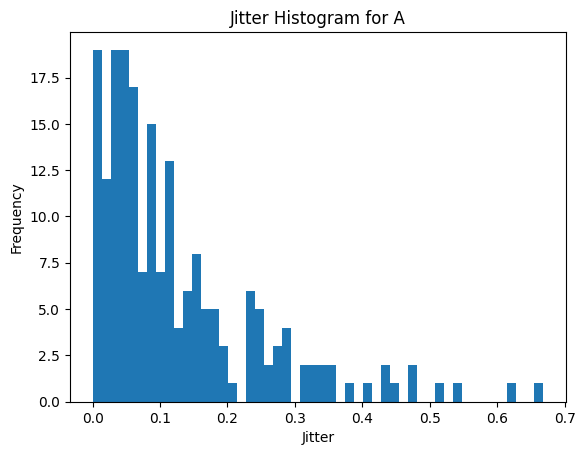

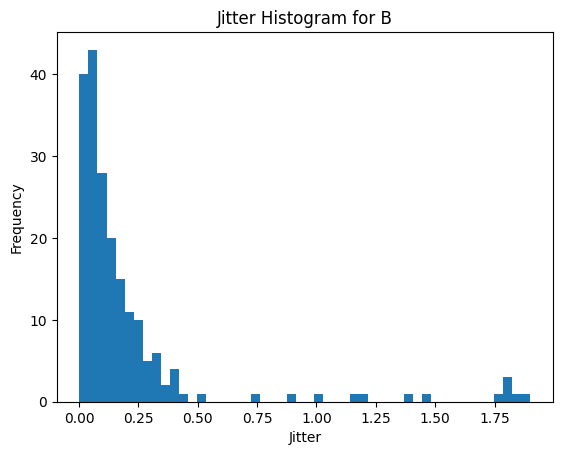

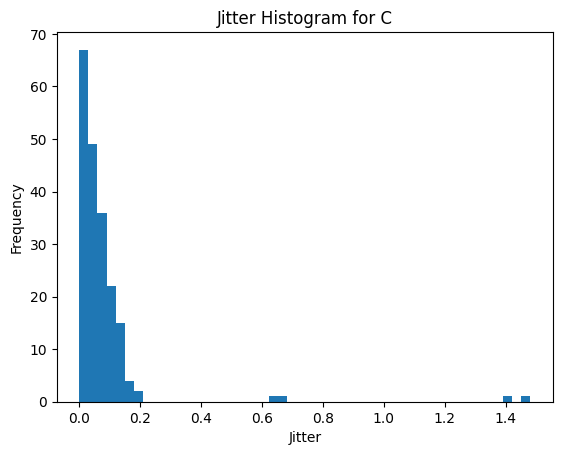

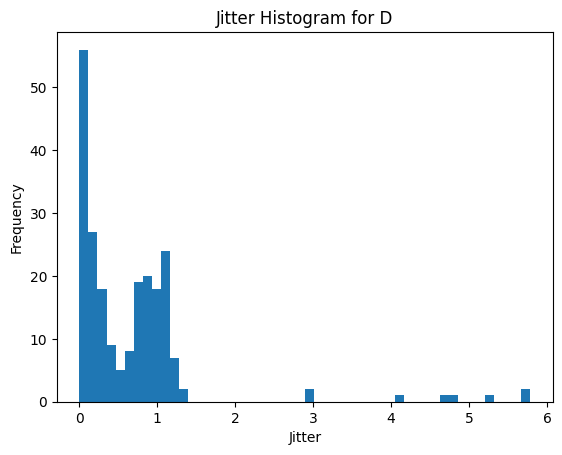

In [3]:
# Plot the histograms of the ping values
for name, ping in ping_ls:
	display_histogram(name, ping)

### Compute Probability of Success Analytically

In [4]:
# Compute the probability that |J| < T
def compute_analytical_joint_probability(machine_name, race_window_mu, race_window_std_dev, mu, std_dev):
    joint_mu = mu - race_window_mu
    joint_std_dev = math.sqrt(std_dev ** 2 + race_window_std_dev ** 2)
    norm_dist = norm(loc=joint_mu, scale=joint_std_dev)
    prob_success = norm_dist.cdf(0)
    
    print(f"Machine {machine_name}'s \tjoint mu: {joint_mu:.4f}, \tjoint std dev: {joint_std_dev:.4f}, \tq:\t {prob_success:.4f}")

In [5]:
# Compute the theoretical probability
for name, ping in ping_ls:
	mean = np.mean(ping)
	std = np.std(ping)
	compute_analytical_joint_probability(name, RACE_WINDOW_MU, RACE_WINDOW_SIGMA, mean, std)

Machine A's 	joint mu: -1.4328, 	joint std dev: 1.4238, 	q:	 0.8429
Machine B's 	joint mu: -1.3515, 	joint std dev: 1.4624, 	q:	 0.8223
Machine C's 	joint mu: -1.4829, 	joint std dev: 1.4268, 	q:	 0.8507
Machine D's 	joint mu: -0.8860, 	joint std dev: 1.6668, 	q:	 0.7025


In [7]:
def compute_theoretical_joint_probability_exp(machine_name, race_window_mu, mu):
	lambda_1 = 1 / mu
	lambda_2 = 1 / race_window_mu
	print(f"Machine {machine_name}'s lambda: {lambda_1:.4f} \tq: {(lambda_1 / (lambda_1 + lambda_2)):.4f}")

for name, jitter in ping_ls:
	mean = np.mean(jitter)
	compute_theoretical_joint_probability_exp(name, RACE_WINDOW_MU, mean)

Machine A's lambda: 7.8803 	q: 0.9248
Machine B's lambda: 4.8028 	q: 0.8822
Machine C's lambda: 13.0231 	q: 0.9531
Machine D's lambda: 1.4844 	q: 0.6984
